<a href="https://colab.research.google.com/github/Thiago1alberto/ProjetosAnaliseDeDados/blob/main/Petr4_previs%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importando base de dados:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, InputLayer, LSTM
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_squared_error
import math
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
b3_stocks_path = '/content/drive/MyDrive/dataSet/ibovespa/b3_stocks_1994_2020.csv'
selic_path = '/content/drive/MyDrive/dataSet/ibovespa/selic.csv'
usd2brl_path = '/content/drive/MyDrive/dataSet/ibovespa/usd2brl.csv'

## Pré-processamento dos dados:

In [ ]:
petr4_df = b3_stocks_data[b3_stocks_data['ticker'] == 'PETR4']
petr4_df.head()

,datetime,ticker,open,close,high,low,volume
209606,1998-03-16,PETR4,276.0,275.0,276.0,273.99,27078933.9
209805,1998-03-17,PETR4,275.0,277.0,278.0,274.50,41049029.3
210027,1998-03-18,PETR4,277.0,275.5,279.0,275.00,40506405.9
210261,1998-03-19,PETR4,275.5,275.5,277.0,272.00,29801256.4
210497,1998-03-20,PETR4,277.0,279.0,280.0,276.00,26713421.3


In [ ]:
petr4_df_copy = petr4_df.copy()

petr4_df_copy['datetime'] = pd.to_datetime(petr4_df_copy['datetime'])
petr4_df_copy['datetime'] = petr4_df_copy['datetime'].dt.strftime('%d/%m/%Y')

petr4_df_copy.head()

<ipython-input-113-cfb58bc9c95f>:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  petr4_df_copy['datetime'] = pd.to_datetime(petr4_df_copy['datetime'])


,datetime,ticker,open,close,high,low,volume
209606,16/03/1998,PETR4,276.0,275.0,276.0,273.99,27078933.9
209805,17/03/1998,PETR4,275.0,277.0,278.0,274.50,41049029.3
210027,18/03/1998,PETR4,277.0,275.5,279.0,275.00,40506405.9
210261,19/03/1998,PETR4,275.5,275.5,277.0,272.00,29801256.4
210497,20/03/1998,PETR4,277.0,279.0,280.0,276.00,26713421.3


In [ ]:
data = petr4_df['close']
len(data)

5640

##Série Temporal

In [ ]:
forecasting_period = 5

In [ ]:
def df_to_X_y(df):
  df = df.to_numpy()
  x = []
  y = []
  for i in range(len(df) - forecasting_period):
    row = [[a] for a in df[i:i+5]]
    x.append(row)
    label = df[i+5]
    y.append(label)
  return np.array(x), np.array(y)

In [ ]:
X, y = df_to_X_y(data)
X.shape, y.shape

((5635, 5, 1), (5635,))

In [ ]:
train_size = round(len(data) * 0.8)
test_and_val_size = (len(data) - train_size) / 2
train_size, test_and_val_size

(4512, 564.0)

In [ ]:
X_train, y_train = X[:4512], y[:4512]
X_val, y_val = X[4512:5076], y[4512:5076]
X_test, y_test = X[5076:], y[5076:]

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((4512, 5, 1), (564, 5, 1), (559, 5, 1))

In [ ]:
y_train.shape, y_val.shape, y_test.shape

((4512,), (564,), (559,))

In [ ]:
model = Sequential()
model.add(InputLayer(input_shape=(5, 1)))
model.add(LSTM(units=64))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=1, activation='linear'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.save('PETR4-LSTM.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.compile(loss=MeanSquaredError(), optimizer='adam', metrics=[RootMeanSquaredError()])

In [ ]:
checkpoint = ModelCheckpoint('model/', save_best_only=True)

In [ ]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[checkpoint])

Epoch 1/20
141/141 [==============================] - 7s 34ms/step - loss: 175.3387 - root_mean_squared_error: 13.2416 - val_loss: 0.6952 - val_root_mean_squared_error: 0.8338
Epoch 2/20
141/141 [==============================] - 5s 36ms/step - loss: 155.5756 - root_mean_squared_error: 12.4730 - val_loss: 0.3117 - val_root_mean_squared_error: 0.5583
Epoch 3/20
141/141 [==============================] - 1s 5ms/step - loss: 145.4998 - root_mean_squared_error: 12.0623 - val_loss: 1.5892 - val_root_mean_squared_error: 1.2606
Epoch 4/20
141/141 [==============================] - 1s 5ms/step - loss: 143.7576 - root_mean_squared_error: 11.9899 - val_loss: 0.3351 - val_root_mean_squared_error: 0.5788
Epoch 5/20
141/141 [==============================] - 1s 5ms/step - loss: 160.2216 - root_mean_squared_error: 12.6579 - val_loss: 0.5423 - val_root_mean_squared_error: 0.7364
Epoch 6/20
141/141 [==============================] - 1s 5ms/step - loss: 171.3144 - root_mean_squared_error: 13.0887 - val

In [ ]:
model = load_model('model/')

In [ ]:
predict = model.predict(X_train)

141/141 [==============================] - 1s 2ms/step


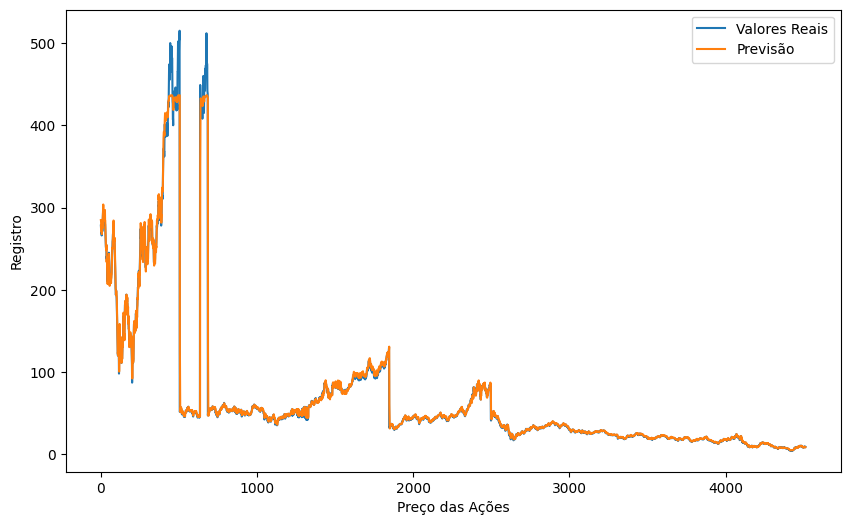

In [ ]:
fig = plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Valores Reais')
plt.plot(predict, label='Previsão')
plt.xlabel('Preço das Ações')
plt.ylabel('Registro')
plt.legend()
plt.show()

18/18 [==============================] - 0s 3ms/step


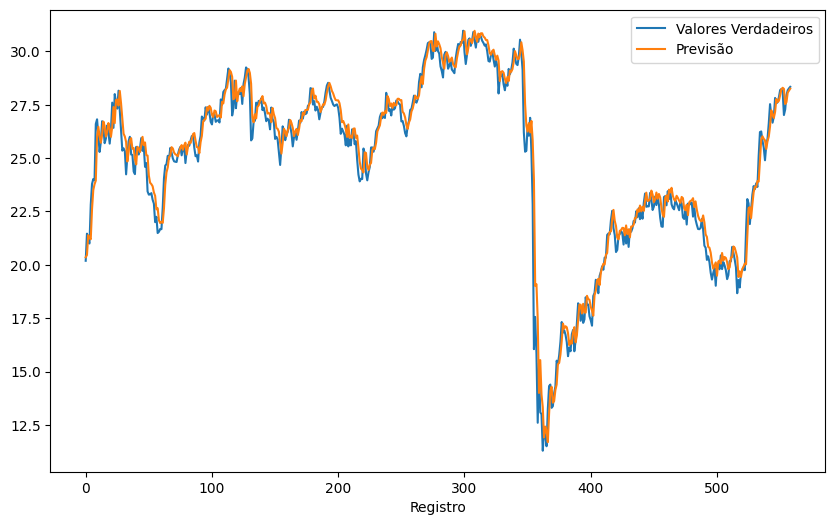

In [ ]:
test_predict = model.predict(X_test)

fig = plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Valores Verdadeiros')
plt.plot(test_predict, label='Previsão')
plt.xlabel('Registro')
plt.legend()

plt.show()

In [ ]:
test_predict = model.predict(X_test)
rmse = math.sqrt(mean_squared_error(y_test, test_predict))
print(f"RMSE no conjunto de teste: {rmse}")

18/18 [==============================] - 0s 2ms/step
RMSE no conjunto de teste: 0.7703743981237237
